Naive implementation of the dendrogram
======================================

In this notebook we discuss implementations of the dendrogram that are easy to code and are not very generic.
We start with the one that is used in Astrodendro and then develop one in 1D that is vectorized but still not very generic.

First, let's get the imports out of the way

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, cut_tree
from astrodendro import Dendrogram

Next, let's define some data with some some Gaussian peaks

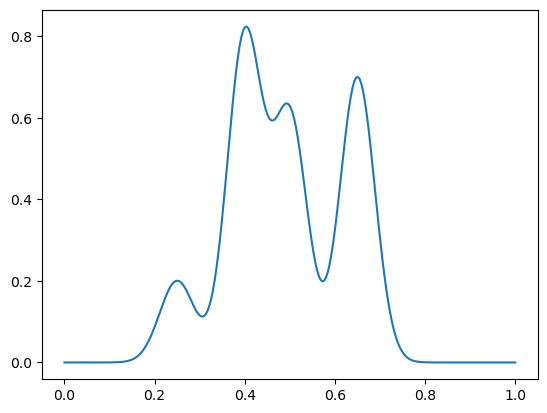

In [2]:
x = np.linspace(0, 1, 256)

peaks = [0.25, 0.4, 0.5, 0.65]
heights = [0.2, 0.8, 0.6, 0.7]

data = np.zeros_like(x)
for peak, height in zip(peaks, heights):
    data += height * np.exp(-((x - peak) ** 2) / 0.003)

fig, ax = plt.subplots()
ax.plot(x, data)

Ok, what does Astrodendro do with this data?

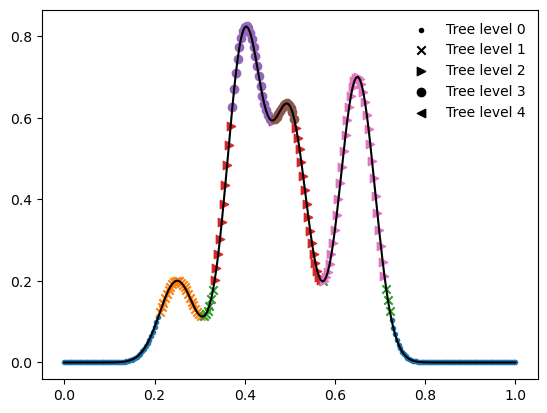

In [3]:
d = Dendrogram.compute(data)
markers = {0: ".", 1: "x", 2: ">", 3: "o", "4": "<"}


def plot_astrodendro_leaves(ax, leaves, level=0):
    for leaf in leaves:
        ax.scatter(x[leaf._indices], data[leaf._indices], marker=markers[level])
        plot_astrodendro_leaves(ax=ax, leaves=leaf._children, level=level + 1)


fig, ax = plt.subplots()
ax.plot(x, data, color="black")
plot_astrodendro_leaves(ax, d.trunk, level=0)

for level in markers.keys():
    ax.scatter(
        [None],
        [None],
        marker=markers[level],
        label=f"Tree level {level}",
        color="black",
    )
ax.legend(frameon=False)

Astrodendro computes a tree structure. Sadly, I don't know how to plot the tree in this plot.
The markerstyles denote the level in the tree and the colors denote individual features.

Astrodendro starts from the top down, sorting the data and looping through every point, assigning it to an existing structure or beginning a new structure based on whether it is adjacent to an existing structure.

As you can see, leaves begin at a local minimum and encapsulate a local maximum.
They are joined to branches at local minima.

Ok, now let's try to replicate this using a still very naive, but at least vectorized, method.
Note that this only works in 1D for now, I have to think of how to extend this to 2D.

In this method, we start from the bottom and work our way up recursively.
We start with all the values and go looking for the smallest local minimum within these data, as that is where the tree bifurcates.
We assign all data that are smaller than the local minimum to the trunk and remove this from the data that remain to be clustered.
Then, we split the at the local minimum and recursively apply this procedure to the data left and right of the minimum that has not yet been clustered.

In order to find the local minima, we first compute the derivative with a simple finite difference approximation $\partial_x f(x) \approx (f(x+\Delta x) - f(x)) / \Delta x$.
Then, we look for sign changes to find extrema.
Finally, the local minima are every other extremum.
In practice, this should be done by checking the second derivative, but it will suffice here.

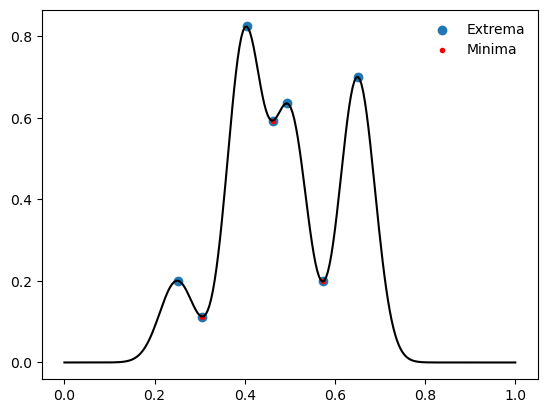

In [4]:
deriv = np.append(
    (data[0] - data[1]) / (x[0] - x[1]), (data[1:] - data[:-1]) / (x[1:] - x[:-1])
)
sign = np.sign(deriv)
sign_change = np.cumsum(np.append([0], -(sign[1:] / sign[:-1] - 1) / 2))
extrema = np.append(sign_change[1:] - sign_change[:-1], [0]) == 1

extrema_x = x[extrema]
extrema_y = data[extrema]
minima_x = extrema_x[1::2]
minima_y = extrema_y[1::2]

fig, ax = plt.subplots()
ax.plot(x, data, color="black")
ax.scatter(extrema_x, extrema_y, label="Extrema", marker="o")
ax.scatter(minima_x, minima_y, label="Minima", marker=".", color="red")
ax.legend(frameon=False)

We see that our derivative approximation is not perfect, but it will do for now.

In the next step, we compute the actual tree.

In [5]:
def add_structure(mask_remaining):

    # select a minimum in the remaining values that this structure stretches to
    possible_minima = [
        (min_x, min_y)
        for min_y, min_x in zip(minima_y, minima_x)
        if min_x in x[mask_remaining]
    ]
    if len(possible_minima) == 0:
        print(
            f"Found leaf between {min(x[mask_remaining]):.2f} and {max(x[mask_remaining]):.2f}"
        )
        return [mask_remaining]  # we have reached a leaf at the end of the tree

    next_minimum_idx = np.argmin([me[1] for me in possible_minima])
    next_minimum_x = possible_minima[next_minimum_idx][0]
    next_minimum_y = possible_minima[next_minimum_idx][1]

    structure = np.logical_and(mask_remaining, data <= next_minimum_y)

    mask_remaining = np.logical_and(mask_remaining, ~structure)

    # split the tree at the minimum
    mask_left = np.logical_and(x < next_minimum_x, mask_remaining)
    mask_right = np.logical_and(x > next_minimum_x, mask_remaining)

    print(
        f"Values in structure: {len(x[structure])}, {len(x[mask_left])} values left of local minimum at {next_minimum_x:.2f} and {len(x[mask_right])} to the right."
    )
    left_leaf = [None]
    right_leaf = [None]
    if any(mask_left):
        left_leaf = add_structure(mask_left)
    if any(mask_right):
        right_leaf = add_structure(mask_right)
    return [[structure] + left_leaf + right_leaf]


tree = add_structure(np.ones_like(x).astype(bool))[0]

Values in structure: 126, 24 values left of local minimum at 0.31 and 106 to the right.
Found leaf between 0.21 and 0.30
Values in structure: 10, 61 values left of local minimum at 0.57 and 35 to the right.
Values in structure: 26, 23 values left of local minimum at 0.46 and 12 to the right.
Found leaf between 0.37 and 0.46
Found leaf between 0.47 and 0.51
Found leaf between 0.58 and 0.71


This tree is a list.
The first entry contains a mask of the structure at the current level, and the next entries contain the left and right children respectively.
The children may either be structures (i.e. masks) if they are leaves or lists if they contain further branches.

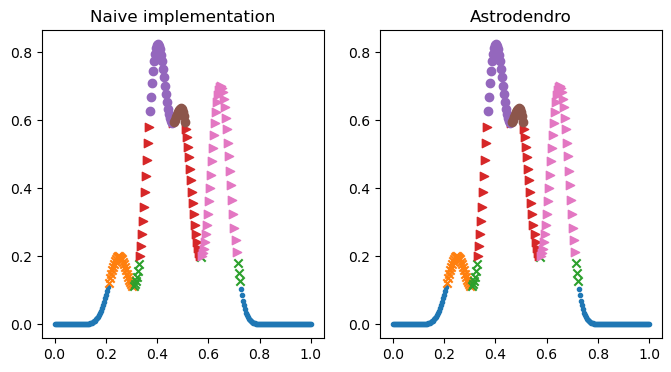

In [6]:
def plot_dendrogram_leaves(ax, tree, level=0):
    ax.scatter(x[tree[0]], data[tree[0]], marker=markers[level])
    for child in tree[1:]:
        if isinstance(child, type(x)):
            ax.scatter(x[child], data[child], marker=markers[level + 1])
        else:
            plot_dendrogram_leaves(ax=ax, tree=child, level=level + 1)


fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title("Naive implementation")
plot_dendrogram_leaves(axs[0], tree)
axs[1].set_title("Astrodendro")
plot_astrodendro_leaves(axs[1], d.trunk)
plt.show()

We have reproduced the Astrodendro tree, which is nice!
This has limitations, though:
- Extension to 2D not trivial
- Very specific to these kinds of data
- Not sure if the masking is ok from a performance point of view